# SMS Spam Messages Classification

**Goal**: Classify Spam Messages. Compare Tfid with plain text results, Hash Vectorizer with n-Grams results where n=2, and Burrows Wheeler Transform Distance (BWTD) with plain text and n-gram results.<br>
**Approach**:
<ol>
    <li>Supervised Learning task, because given labeled traning examples</li>
    <li>Binary Classification task</li>
    <li>Use plain text with Tfid</li>
    <li>Use N-Grams with Hash Vectorizer</li>
    <li>Use plain text with BWTD</li>
    <li>Use N-Grams with BWTD</li>
    <li>There is no continuous flow of data, no need to adjust to changing data, and the data is small enough to fit in memmory: Batch Learning</li>
</ol>

**Data:** [SMS Spam Collection Dataset | Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset)<br>
**BWTD:** [Burrows Wheeler Transform Distance (BWTD) by Dr. Edward Raff](https://github.com/EdwardRaff/pyBWMD)<br><br>
**Project Author:** Maksim Ekin Eren

## Libraries Needed

In [1]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pyBWMD import vectorize
from sklearn.feature_extraction.text import HashingVectorizer

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [6]:
import collections
import re
import os 

## Helper Functions for the Models

In [7]:
# function to print out classification model report
def classification_report(model_name, test, pred, label):    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, pos_label=label)) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, pos_label=label)) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, pos_label=label)) * 100), "%")

## Load the Data

In [8]:
# function to load the data
def load_data(path, file):
    csv_path = os.path.join(path, file)
    return pd.read_csv(csv_path, low_memory=False, encoding = "ISO-8859-1")

# load data
data = load_data("data", "spam.csv")

# let's take a look at the top 5 instances
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Pre-Processing
Remove punctuation from each text:

In [10]:
data['v2'] = data['v2'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

Convert each text to lowercase:

In [11]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

data['v2'] = data['v2'].apply(lambda x: lower_case(x))

In [12]:
data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,go until jurong point crazy available only in ...,NaN,NaN,NaN
1,ham,ok lar joking wif u oni,NaN,NaN,NaN
2,spam,free entry in 2 a wkly comp to win fa cup fina...,NaN,NaN,NaN


## Separete Features from Labels

In [13]:
text = data.drop(["v1", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
y = data["v1"].values.copy()

In [14]:
text_arr = text.stack().tolist()
text_arr[0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

In [15]:
len(text_arr)

5572

In [16]:
y = (y == 'spam')
y

array([False, False,  True, ..., False, False, False])

In [17]:
len(y)

5572

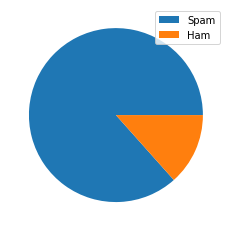

In [18]:
plt.pie(data['v1'].value_counts() )
plt.legend(['Spam','Ham'])

## Classify using Tfid and Plain Text
### Separete Training and Test Set

In [19]:
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(text_arr, y, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print(" X_test size:", len(X_test), "\n")

print("y_train size:", len(y_train))
print(" y_test size:", len(y_test))

X_train size: 4457
 X_test size: 1115 

y_train size: 4457
 y_test size: 1115


### Vectorize

In [20]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [21]:
X_train_vec.shape

(4457, 8344)

In [22]:
X_test_vec.shape

(1115, 8344)

### Random Forest

In [23]:
# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train_vec, y_train, cv=5, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  97.218 %


In [24]:
# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train_vec, y_train, cv=5, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")

Precision:  100.000 %
   Recall:  100.000 %


In [25]:
# first train the model
forest_clf.fit(X_train_vec, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test_vec)

# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred, 1)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  97.130 %
     Precision:  100.000 %
        Recall:  78.667 %
      F1 score:  88.060 %


## Classify Using N-Grams
### Generate 2-Grams

In [26]:
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['v2']).split(" "))

In [27]:
words[0]

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [28]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [29]:
n_gram_all[0]

['gountil',
 'untiljurong',
 'jurongpoint',
 'pointcrazy',
 'crazyavailable',
 'availableonly',
 'onlyin',
 'inbugis',
 'bugisn',
 'ngreat',
 'greatworld',
 'worldla',
 'lae',
 'ebuffet',
 'buffetcine',
 'cinethere',
 'theregot',
 'gotamore',
 'amorewat']

### Separete Training and Test Set

In [30]:
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(n_gram_all, y, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print(" X_test size:", len(X_test), "\n")

print("y_train size:", len(y_train))
print(" y_test size:", len(y_test))

X_train size: 4457
 X_test size: 1115 

y_train size: 4457
 y_test size: 1115


### Vectorize 2-Grams Using Hash Vectorizer

In [31]:
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**13, stop_words='.')

# fit transform into the hash vector
X_train = hvec.fit_transform(X_train)
X_test = hvec.transform(X_test)

In [32]:
X_train.shape

(4457, 8192)

In [33]:
X_test.shape

(1115, 8192)

### Random Forest Using 2-Grams:

In [34]:
# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=5, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  95.288 %


In [35]:
# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=5, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")

Precision:  98.254 %
   Recall:  98.254 %


In [36]:
# first train the model
forest_clf.fit(X_train, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test)

# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred, 1)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  95.874 %
     Precision:  99.057 %
        Recall:  70.000 %
      F1 score:  82.031 %


## Classify Using Burrows Wheeler Transform Distance (BWTD)
### Separete Training and Test Set

In [37]:
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(text_arr, y, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print(" X_test size:", len(X_test), "\n")

print("y_train size:", len(y_train))
print(" y_test size:", len(y_test))

X_train size: 4457
 X_test size: 1115 

y_train size: 4457
 y_test size: 1115


### Vectorize

In [38]:
X_train_vec = vectorize(X_train)
X_test_vec = vectorize(X_test)

In [39]:
X_train_vec.shape

(4457, 65536)

In [40]:
X_test_vec.shape

(1115, 65536)

### Random Forest Using BWTD

In [41]:
# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train_vec, y_train, cv=5, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  96.545 %


In [42]:
# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train_vec, y_train, cv=5, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")

Precision:  99.332 %
   Recall:  99.332 %


In [43]:
# first train the model
forest_clf.fit(X_train_vec, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test_vec)

# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred, 1)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  96.771 %
     Precision:  100.000 %
        Recall:  76.000 %
      F1 score:  86.364 %


## Classify Using BWTD With 2-Grams:
### Separete Training and Test Set

In [44]:
n_gram_all = [" ".join(x) for x in n_gram_all]

In [45]:
n_gram_all[0]

'gountil untiljurong jurongpoint pointcrazy crazyavailable availableonly onlyin inbugis bugisn ngreat greatworld worldla lae ebuffet buffetcine cinethere theregot gotamore amorewat'

In [46]:
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(n_gram_all, y, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print(" X_test size:", len(X_test), "\n")

print("y_train size:", len(y_train))
print(" y_test size:", len(y_test))

X_train size: 4457
 X_test size: 1115 

y_train size: 4457
 y_test size: 1115


### Vectorize

In [47]:
X_train_vec = vectorize(X_train)
X_test_vec = vectorize(X_test)

### Random Forest Using BWTD and 2-Grams

In [51]:
# random forest classifier instance
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

# cross validation on the training set 
forest_scores = cross_val_score(forest_clf, X_train_vec, y_train, cv=5, n_jobs=4)

# print out the mean of the cross validation scores
print("Accuracy: ", '{:,.3f}'.format(float(forest_scores.mean()) * 100), "%")

Accuracy:  97.016 %


In [52]:
# cross validate predict on the training set
forest_train_pred = cross_val_predict(forest_clf, X_train_vec, y_train, cv=5, n_jobs=4)

# print precision and recall scores
print("Precision: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")
print("   Recall: ", '{:,.3f}'.format(float(precision_score(y_train, forest_train_pred)) * 100), "%")

Precision:  99.573 %
   Recall:  99.573 %


In [53]:
# first train the model
forest_clf.fit(X_train_vec, y_train)

# make predictions on the test set
forest_pred = forest_clf.predict(X_test_vec)

# print out the classification report
classification_report("Random Forest Classifier Report (Test Set)", y_test, forest_pred, 1)

Random Forest Classifier Report (Test Set) :

Accuracy Score:  97.848 %
     Precision:  99.219 %
        Recall:  84.667 %
      F1 score:  91.367 %
